# Модель машинного обучения для детекции и предотвращения мошенничества в кредитных операциях

**Автор: Кузьмин Дмитрий**

## Этапы работы

1. Сбор и предварительная обработка данных
2. Предварительный анализ и масштабирование признаков
3. Обучение модели и выбор алгоритма
4. Оценка результатов

## О наборе данных

Используемый набор данных содержит транзакции по кредитным картам, совершённые в сентябре 2013 года европейскими держателями карт. Все входные признаки - числовые, являющиеся результатом преобразования главных компонент (PCA), что уменьшает размерность и убирает корреляции.

В наборе 31 числовая переменная, а также следующие важные признаки:

- Time - количество секунд, прошедших с момента первой транзакции в датасете до текущей транзакции. Этот признак помогает учитывать временную динамику транзакций.

- Amount - сумма транзакции, которая может влиять на вероятность мошенничества и использоваться для оценки экономической значимости.

- Class - целевая переменная, которая принимает значение 1 для мошеннических транзакций и 0 для легитимных.

Набор данных сильно несбалансирован: мошенничество составляет лишь 0.172% от всех транзакций (492 мошеннических из 284 807). Из-за отсутствия идентификатора владельца карты каждая транзакция рассматривается как независимый случай.

Для решения этой проблемы при обучении моделей применяется балансировка данных через создание подвыборок с равным соотношением мошеннических и нормальных транзакций - по 50% каждого класса, что позволяет модели лучше распознавать редкие мошеннические случаи и уменьшает риск смещения.

## Технический стек

| Компоненты | Технологии |
|-----------|-----------|
| Язык программирования | Python 3.13 |
| ML Библиоека | scikit-learn 1.6.1 |
| Обработка данных | pandas, numpy |
| Визуализация | matplotlib, seaborn |
| Модели ML | Logistic Regression, Random Forest, Gradient Boosting |

---

## Результаты и метрики моделей
| model                              |   accuracy |   precision |   recall |   f1_score |      auc |
|:-----------------------------------|-----------:|------------:|---------:|-----------:|---------:|
| Random Forest                      |   0.999596 |   0.941176  | 0.816327 |  0.874317  | 0.963027 |
| Gradient Boosting                  |   0.999526 |   0.88172   | 0.836735 |  0.858639  | 0.968385 |
| Decision Trees                     |   0.999508 |   0.87234   | 0.836735 |  0.854167  | 0.973959 |
| Logistic Regression                |   0.99914  |   0.826667  | 0.632653 |  0.716763  | 0.960549 |
| Logistic Regression (Balanced)     |   0.975528 |   0.0609756 | 0.918367 |  0.114358  | 0.972083 |
| Logistic Regression (Undersampled) |   0.960219 |   0.0383305 | 0.918367 |  0.0735895 | 0.976126 |

## Импорт библиотек

In [1]:
import time
import warnings
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve

## Чтение данных

In [2]:
X_train = pd.read_csv('../data/X_train.csv')
X_test = pd.read_csv('../data/X_test.csv')
y_train = pd.read_csv('../data/y_train.csv')
y_test = pd.read_csv('../data/y_test.csv')

## Масштабирование признаков

In [3]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) 
X_test = scaler.transform(X_test)       

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_train = y_train.reset_index(drop=True).squeeze()

## Реализация функции для обучения модели

In [4]:
def train_model(
    model,
    X_train,
    y_train,
    X_test,
    y_test,
    model_name,
    subtitle=None,
    verbose=False,
    show_confusion_matrix=True,
    show_roc_auc=True,
):
    header = f"{model_name}"
    if verbose:
        print("=" * len(header))
        print(header)
        print("=" * len(header))
    
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    auc_score = roc_auc_score(y_test, y_pred_proba)

    cm = confusion_matrix(y_test, y_pred, labels=[1, 0])
    
    if verbose:
        print("\nClassification Report:")
        print(
            classification_report(
                y_test,
                y_pred,
                target_names=["Fraud", "Normal"],
                labels=[1, 0],
            )
        )
        
        print(f"\nROC AUC Score: {auc_score:.4f}")
        print(f"Training Time: {training_time:.2f}s")

    if show_confusion_matrix:
        plt.figure(figsize=(6, 5))
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=["Fraud", "Normal"],
            yticklabels=["Fraud", "Normal"],
        )
        title = f"Confusion Matrix - {model_name}"
        if subtitle:
            title += f"\n{subtitle}"
        plt.title(title, fontweight="bold", fontsize=14, pad=20)
        plt.show()


    if show_roc_auc:
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        title = f'ROC Curve - {model_name}'
        if subtitle:
            title += f'\n{subtitle}'
        plt.title(title, fontweight='bold', fontsize=14, pad=20)
        plt.legend(loc="lower right")
        plt.grid(alpha=0.3)
        plt.show()

    results = {
        "model": model,
        "model_name": model_name,
        "predictions": y_pred,
        "probabilities": y_pred_proba,
        "auc_score": auc_score,
        "confusion_matrix": cm,
        "timing": {
            "training_time": training_time,
        },
    }

    return results

## ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ

Для начала будет обучена модель логистической регрессии без применения каких-либо методов балансировки классов. Поскольку эта модель достаточно проста, она служит базовым уровнем для сравнения её производительности с более сложными методами

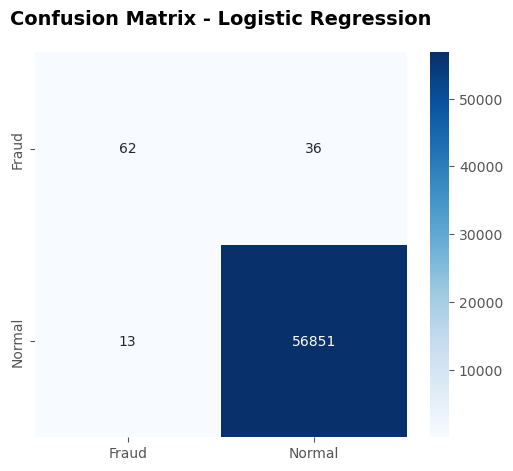

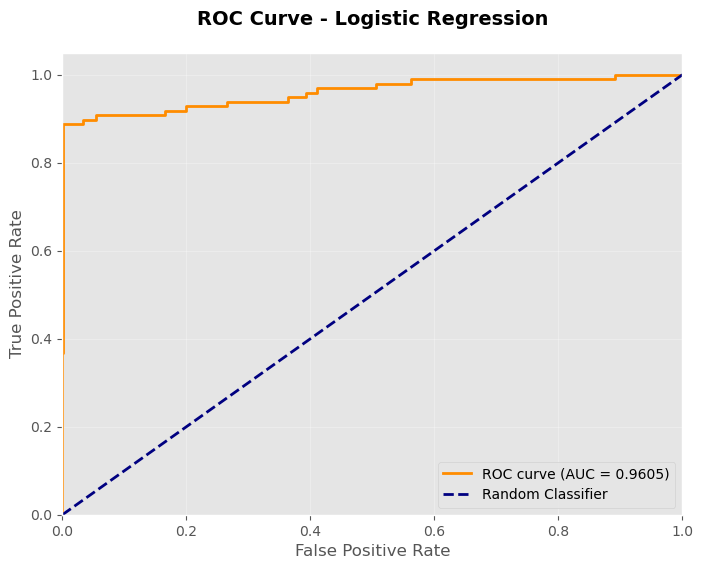

In [5]:
lr_model = LogisticRegression(random_state=42, max_iter=1000)
results_lr = train_model(
    model=lr_model,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model_name="Logistic Regression",
    show_roc_auc=True,
    show_confusion_matrix=True
)


- **Precision:**

    $$
    \text{Precision} = \frac{TP}{TP + FP} = \frac{62}{62+10} = 0.8266
    $$

- **Recall:**

  $$
    \text{Recall} = \frac{TP}{TP + FN} = \frac{62}{62+36} = 0.6326
  $$

- **F1-Score:** 

    $$
    \text{F1-Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} = 2\times \frac{0.8266 \times 0.6326}{0.8266 + 0.6326} = 0.72
    $$

## ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ C ВЗВЕШИВАНИЕМ КЛАССОВ

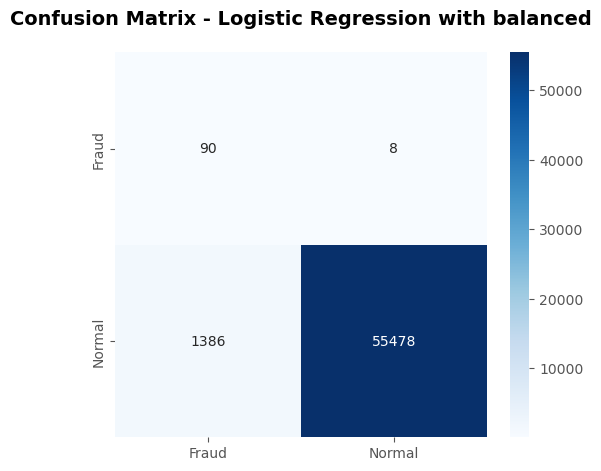

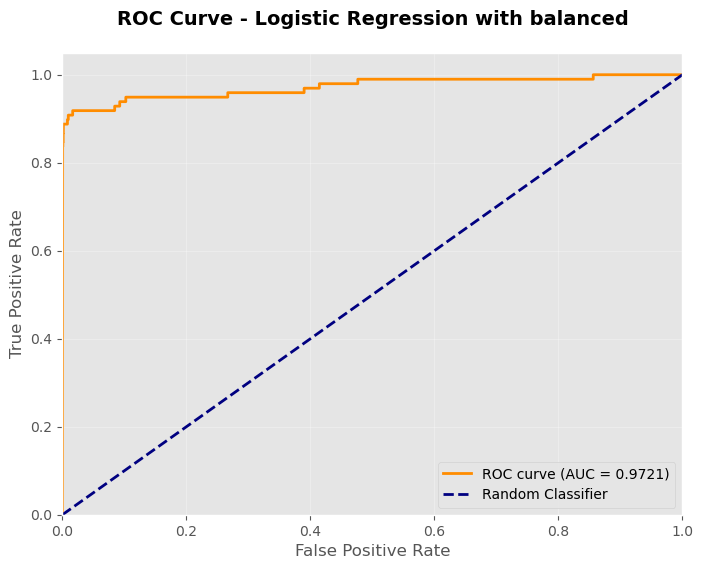

In [6]:
lr_balanced = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
results_lr_balanced = train_model(
    model=lr_balanced,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model_name="Logistic Regression with balanced",
    show_roc_auc=True,
    show_confusion_matrix=True
)


- **Precision:**
    $$
    \text{Precision} = \frac{TP}{TP + FP} = \frac{90}{90+1386} = 0.061
    $$
  
- **Recall:** 

  $$
    \text{Recall} = \frac{TP}{TP + FN} = \frac{90}{90+8} = 0.9184
  $$

- **F1-Score:**

    $$
    \text{F1-Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} = 2\times \frac{0.0609 \times 0.9183}{0.0609 + 0.9183} = 0.1144
    $$

Модель корректно классифицирует 55 478 нормальных транзакций и обнаруживает 90 из 98 реальных случаев мошенничества. Однако, после повышения Recall вызвало резкое падение Precision. Это значит, что наша модель логистической регрессии начала ошибочно помечать нормальные транзакций как мошенничество. Такая конфигурация модели может быть оправдана только в том случае, если цена пропуска мошеннической транзакции чрезвычайно высока, а затраты на расследование ложных срабатываний относительно невелики. Следует рассмотреть возможность использования других алгоритмов машинного обучения, которые лучше справляются с несбалансированными данными

## ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ (UNDERSAMPLING)

In [7]:
def random_undersample(X, y, random_state=42):

    X_majority = X[y == 0]
    X_minority = X[y == 1]
    y_majority = y[y == 0]
    y_minority = y[y == 1]
    np.random.seed(42)
    indices = np.random.choice(X_majority.index, size=len(X_minority), replace=False) 
    X_majority_undersampled = X_majority.loc[indices] 
    y_majority_undersampled = y_majority.loc[indices]
    X_balanced = pd.concat([X_majority_undersampled, X_minority])
    y_balanced = pd.concat([y_majority_undersampled, y_minority])
    
    return X_balanced, y_balanced

X_train_balanced, y_train_balanced = random_undersample(X_train, y_train)

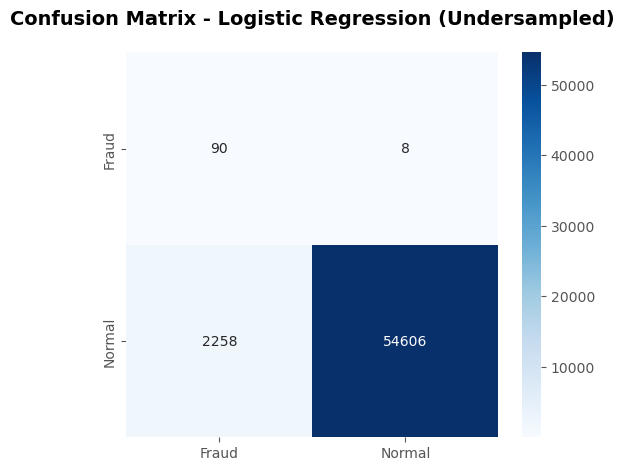

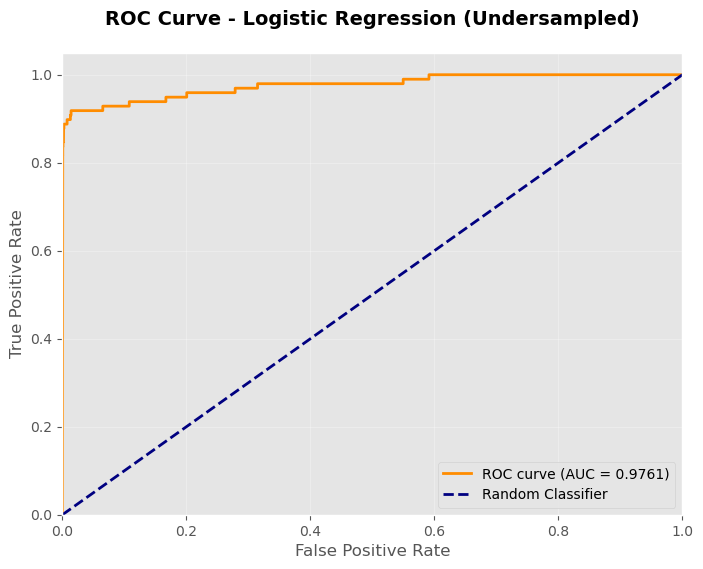

In [8]:
lr_undersampled = LogisticRegression(random_state=42, max_iter=1000)

results_lr_undersampled = train_model(
    model=lr_undersampled,
    X_train=X_train_balanced,
    y_train=y_train_balanced,
    X_test=X_test,
    y_test=y_test,
    model_name="Logistic Regression (Undersampled)",
    show_roc_auc=True,
    show_confusion_matrix=True
)

- **Precision:** 
    $$
    \text{Precision} = \frac{TP}{TP + FP} = \frac{90}{90+2258} = 0.383
    $$

- **Recall:**

  $$
    \text{Recall} = \frac{TP}{TP + FN} = \frac{90}{90+8} = 0.9184
  $$

- **F1-Score:** 

    $$
    \text{F1-Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} = 2\times \frac{0.384 \times 0.9183}{0.384 + 0.9183} = 0.0736
    $$

Модель корректно идентифицирует 55 606 нормальных транзакций и обнаруживает 90 из 98 реальных случаев мошенничества, оставляя необнаруженными только 8. Но, количество сгенерированных ложных срабатываний оставляет желать лучшего

Проблема в том, что для обучения модель использовали сильно урезанный набор данных, где мошеннических и обычных транзакций было поровну. В реальной жизни мошеннических транзакций очень мало, поэтому модель просто забыла, как выглядят настоящие, нормальные транзакции и начала подозревать все подряд.

В итоге, модель стала слишком чувствительной и генерирует слишком много ложных срабатываний, что делает ее бесполезной для практического применения

## СЛУЧАЙНЫЙ ЛЕС (RANDOM FOREST)

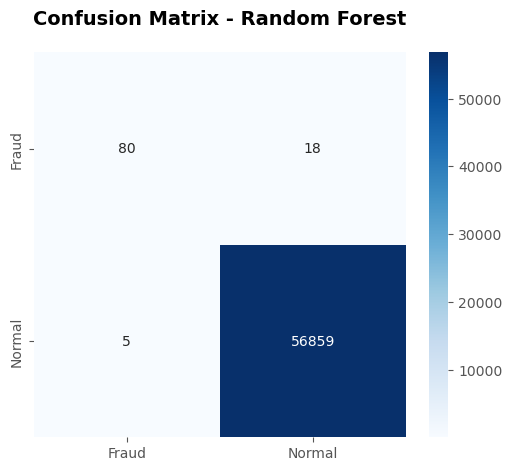

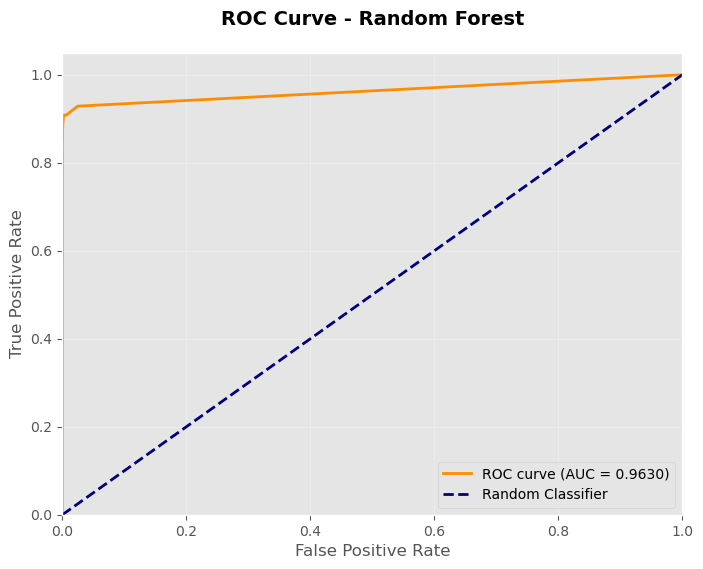

In [9]:
rf_default = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

results_rf_default = train_model(
    model=rf_default,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model_name="Random Forest",
    show_roc_auc=True,
    show_confusion_matrix=True
)

- **Precision:** 
    $$
    \text{Precision} = \frac{TP}{TP + FP} = \frac{80}{80+5} = 0.9412
    $$

- **Recall:**

  $$
    \text{Recall} = \frac{TP}{TP + FN} = \frac{90}{90+18} = 0.8163
  $$

- **F1-Score:** 

    $$
    \text{F1-Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} = 2\times \frac{0.9412 \times 0.8163}{0.9412 + 0.8163} = 0.8743
    $$

Модель демонстрирует рекордную точность 94% - всего 5 ложных срабатываний. Это лучший выбор, когда критически важно минимизировать ложные тревоги. При этом модель сохраняет хороший уровень обнаружения (82% - 18 пропущенных случаев). F1-мера 0.87 делает ее надежным решением для большинства практических задач.

## ДЕРЕВЬЯ РЕШЕНИЙ (BAGGING/DECISION TREES)

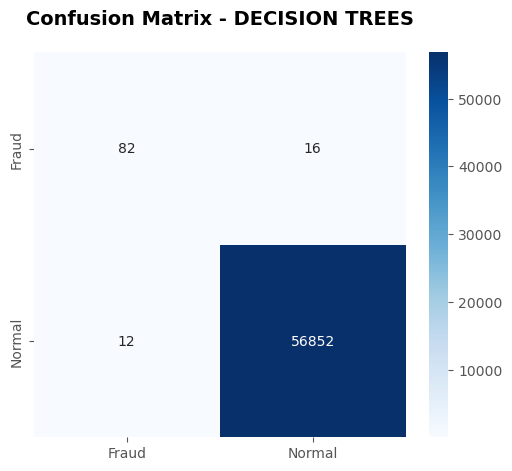

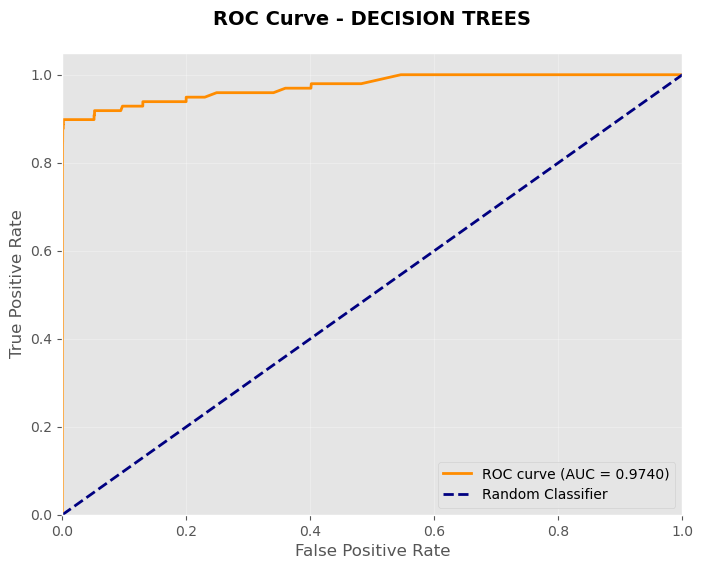

In [10]:
bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(
        max_depth=10, 
        min_samples_split=20,
        min_samples_leaf=10,
    ),
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
)

results_bagging = train_model(
    model=bagging,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model_name="DECISION TREES",
    show_roc_auc=True,
    show_confusion_matrix=True,
)

- **Precision:** 
    $$
    \text{Precision} = \frac{TP}{TP + FP} = \frac{82}{82+12} = 0.8723
    $$

- **Recall:**

  $$
    \text{Recall} = \frac{TP}{TP + FN} = \frac{82}{82+16} = 0.8367
  $$

- **F1-Score:** 

    $$
    \text{F1-Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} = 2\times \frac{0.8723 \times 0.8367}{0.8723 + 0.8367} = 0.8541
    $$

Алгоритм показывает очень высокое качество классификации (ROC-AUC 0.974 - лучший показатель), что означает превосходное различение мошеннических и нормальных операций. F1-мера 0.85 близка к лидерам, однако главный недостаток - огромное время обучения, что делает его неудобным для частых переобучений модели.

## ГРАДИЕНТНЫЙ БУСТИНГ (XGBOOST)

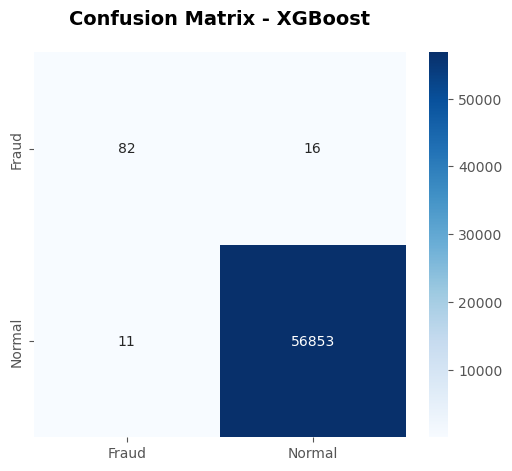

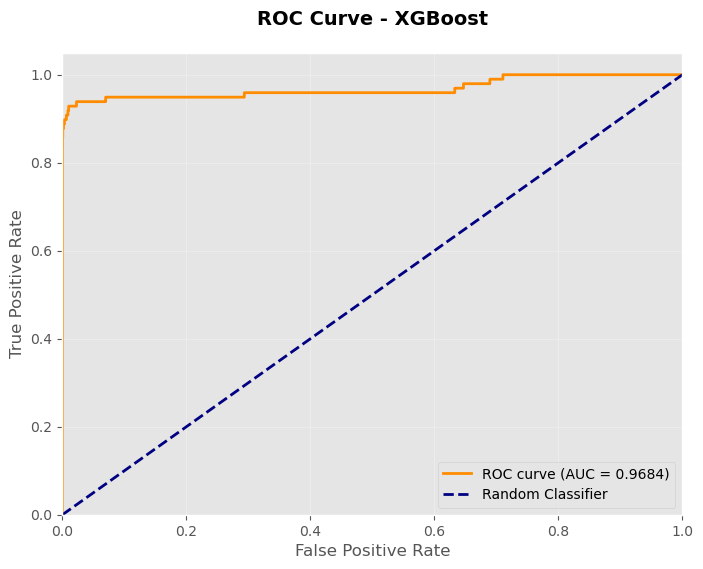

In [11]:
xgboost = XGBClassifier(
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    max_depth=6,
    learning_rate=0.1,
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

results_xgboost = train_model(
    model=xgboost,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model_name="XGBoost",
    show_confusion_matrix=True
)

- **Precision:** 
    $$
    \text{Precision} = \frac{TP}{TP + FP} = \frac{82}{82+11} = 0.8817
    $$

- **Recall:**

  $$
    \text{Recall} = \frac{TP}{TP + FN} = \frac{82}{82+16} = 0.8367
  $$

- **F1-Score:** 

    $$
    \text{F1-Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} = 2\times \frac{0.8817 \times 0.8367}{0.8817 + 0.8367} = 0.8586
    $$

Этот алгоритм показал наилучший баланс характеристик. Он достигает высокой точности (88% - только 11 ложных тревог) и хорошей полноты (84% - всего 16 пропущенных мошенничеств). F1-мера 0.86 подтверждает оптимальное соотношение между обнаружением мошенничества и минимизацией неудобств для клиентов. 

## Результаты

In [12]:
# First define the models dictionary
models = {}

model_configs = [
    ("Logistic Regression", results_lr),
    ("Logistic Regression (Balanced)", results_lr_balanced),
    ("Logistic Regression (Undersampled)", results_lr_undersampled),
    ("Random Forest", results_rf_default),
    ("Decision Trees", results_bagging),
    ("Gradient Boosting", results_xgboost)
]

for name, results in model_configs:
    models[name] = {
        "y_pred": results["predictions"],
        "probabilities": results["probabilities"],
        "auc": results["auc_score"],
        "confusion_matrix": results["confusion_matrix"],
    }

In [13]:
results_df = []
for name, result in models.items():
    
    y_pred = result["y_pred"]
    probabilities = result["probabilities"]
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, probabilities)
    
    results_df.append(
        {
            "model": name,
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1,
            "auc": auc
        }
    )
    
results_df = pd.DataFrame(results_df).sort_values('f1_score', ascending=False)

print("\n" + "=" * 80)
print("РЕЗУЛЬТАТЫ МОДЕЛЕЙ")
print("=" * 80)

results_df


РЕЗУЛЬТАТЫ МОДЕЛЕЙ


,model,accuracy,precision,recall,f1_score,auc
3,Random Forest,0.999596,0.941176,0.816327,0.874317,0.963027
5,Gradient Boosting,0.999526,0.881720,0.836735,0.858639,0.968385
4,Decision Trees,0.999508,0.872340,0.836735,0.854167,0.973959
0,Logistic Regression,0.999140,0.826667,0.632653,0.716763,0.960549
1,Logistic Regression (Balanced),0.975528,0.060976,0.918367,0.114358,0.972083
2,Logistic Regression (Undersampled),0.960219,0.038330,0.918367,0.073590,0.976126


Выбор конкретной модели должен основываться на бизнес-требованиях и приемлемом уровне риска, учитывая важность точности, скорости и полноты обнаружения мошеннических операций. При этом, критически важно оценивать результаты на основе Precision-Recall кривой, а не ROC-AUC, из-за несбалансированности данных

По результатам, для выявления мошеннических транзакций было отобрано три наиболее эффективных модели: Случайный лес, Градиентный бустинг и Дерево решений. Каждая модель обладает своими сильными сторонами и подходит для разных приоритетов

- Случайный лес показал наивысшую точность и рекомендуется для использования, когда минимизация ложных блокировок честных клиентов является приоритетом
- Градиентный бустинг демонстрирует оптимальный баланс между точностью и скоростью обучения, что делает его идеальным для систем, требующих быстрой адаптации к новым типам мошенничества.
- Дерево решений обеспечивает максимальный охват, обнаруживая наибольшее количество потенциальных мошеннических транзакций, и подходит для сценариев, где выявление всех возможных угроз важнее, чем минимизация ложных срабатываний, однако очень долгая в обучении и не подходит для постоянного переобучения